In [223]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Import data

In [148]:
data = pd.read_csv('diabetes_data_upload.csv', header=0)

### Data pre-processing

In [149]:
for column in list(data.columns.values)[2:-1]:
    data[column] = data[column].map({'Yes': 1, 'No': 0})
    
data['Gender'] = data['Gender'].map({'Female': 1, 'Male': 0})
data['class'] = data['class'].map({'Positive': 1, 'Negative': 0})

In [166]:
data.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class,age
0,40,0,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1,middle
1,58,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,elderly
2,41,0,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1,middle
3,45,0,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1,middle
4,60,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,elderly


### Plotting histogram for age distribution

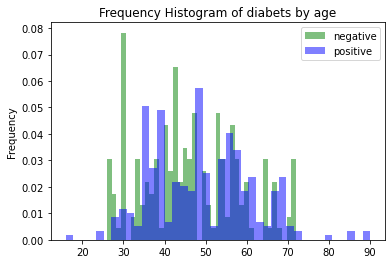

In [164]:
x1 = data.loc[data['class']==0, 'Age']
x2 = data.loc[data['class']==1, 'Age']

plt.hist(x1, alpha=0.5, bins=40, color='g', density=True, label='negative')
plt.hist(x2, alpha=0.5, bins=40, color='b', density=True, label='positive')

plt.gca().set(title='Frequency Histogram of diabets by age', ylabel='Frequency')
plt.legend()

Binarize feature 'age' 

In [165]:
data['age'] = pd.cut(data['Age'], bins=[0, 35, 50, float('Inf')], labels=['young', 'middle', 'elderly'])
one_hot = pd.get_dummies(data['age'])
data = data.drop('age',axis = 1)
data = data.drop('Age',axis = 1)
data = data.join(one_hot)
data.head()

In [170]:
y = data['class']
X = data.drop(['class'], axis=1)

In [ ]:
X_train = X_train.values
    y_train = y_train.values
    X_test = X_test.values
    y_test = y_test.values

### Power, support and confidence functions

In [230]:
def power(X_train, y_train, X_test, y_test, threshold):
    """
    making decision depending on power of intersections: aggregating among all elements in train_positive and 
    train_negative and normalized on number of objects in each class
    """
    accuracy = []
    precision = []
    recall = []
    y_pred = []
    n_attr = len(X_train[0])
    X_train_positive = X_train[y_train == 1]
    X_train_negative = X_train[y_train == 0]
    for object_ in X_test:
        power_positive = np.sum(object_ == X_train_positive) / n_attr / len(X_train_positive) 
        power_negative = np.sum(object_ == X_train_negative) / n_attr / len(X_train_negative) 
        y_pred.append(int(power_positive - power_negative > threshold))
    
    return accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), confusion_matrix(y_test, y_pred)

In [228]:
def support(X_train, y_train, X_test, y_test, threshold):
    """
    making decision depending on the rate of support of intersections within each class
    support of intersection by opposite class doesn't block assignment to initial class
    """
    y_pred = []
    X_train_positive = X_train[y_train == 1]
    X_train_negative = X_train[y_train == 0]
    for object_ in X_test:
        support_positive = 0
        support_negative = 0
        for obj in X_train_positive:
            intersection = object_ == obj
            support_positive += (object_[intersection] == X_train_positive[:, intersection]).all(axis=1).sum()
        for obj in X_train_negative:
            intersection = object_ == obj
            support_negative += (object_[intersection] == X_train_negative[:, intersection]).all(axis=1).sum()
        support_positive = support_positive / len(X_train_positive)**2 # as we have a double loop on X_train_positive
        support_negative = support_negative / len(X_train_negative)**2
        y_pred.append(int(support_positive - support_negative > threshold))
    
    return accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), confusion_matrix(y_test, y_pred)

In [229]:
def confidence(X_train, y_train, X_test, y_test, threshold):
    """
    making decision depending on the rate of confidence of intersections within each class
    the smaller confidence_positive the better for predicting class as positive: if confidence_positive is smaller than 
    confidence_negative than we assing label 1
    """
    y_pred = []
    X_train_positive = X_train[y_train == 1]
    X_train_negative = X_train[y_train == 0]
    for object_ in X_test:
        confidence_positive = 0
        confidence_negative = 0
        for obj in X_train_positive:
            intersection = object_ == obj
            confidence_positive += (object_[intersection] == X_train_negative[:, intersection]).all(axis=1).sum()
        for obj in X_train_negative:
            intersection = object_ == obj
            confidence_negative += (object_[intersection] == X_train_positive[:, intersection]).all(axis=1).sum()
        confidence_positive = confidence_positive / len(X_train_positive) / len(X_train_negative) # as we have a nested loop on X_train_positive, X_train_negative
        confidence_negative = confidence_negative / len(X_train_negative) / len(X_train_positive)
        y_pred.append(int(confidence_negative - confidence_positive > threshold))
    
    return accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), confusion_matrix(y_test, y_pred)

### Performing cross-validation for parameters tuning

In [185]:
from sklearn.model_selection import KFold

100%|██████████| 16/16 [00:00<00:00, 20.53it/s]
No handles with labels found to put in legend.


Text(0.5, 0, 'thresholds')

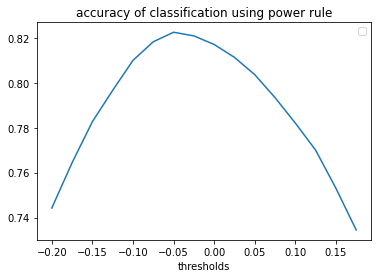

In [214]:
thresholds = np.arange(-0.2, 0.2, 0.025)
accuracy = []
mean_accuracy = []
for threshold in tqdm(thresholds):
    kf = KFold(n_splits=5, shuffle=True, random_state=500)
    for train, test in kf.split(X):
        X_train, X_test, y_train, y_test = X.loc[train, :], X.loc[test, :], y[train], y[test]
        accuracy.append(power(X_train.values, y_train.values, X_test.values, y_test.values, threshold)[0])
    mean_accuracy.append(np.mean(accuracy))
    
    
plt.plot(thresholds, mean_accuracy)
plt.legend()
plt.title('accuracy of classification using power rule')
plt.xlabel('thresholds')

100%|██████████| 10/10 [00:49<00:00,  4.92s/it]
No handles with labels found to put in legend.


Text(0.5, 0, 'thresholds')

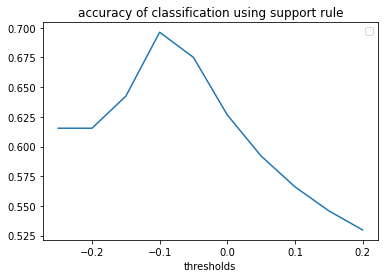

In [203]:
thresholds = np.arange(-0.25, 0.25, 0.05)
accuracy = []
mean_accuracy = []
for threshold in tqdm(thresholds):
    kf = KFold(n_splits=5, shuffle=True, random_state=500)
    for train, test in kf.split(X):
        X_train, X_test, y_train, y_test = X.loc[train, :], X.loc[test, :], y[train], y[test]
        accuracy.append(support(X_train.values, y_train.values, X_test.values, y_test.values, threshold)[0])
    mean_accuracy.append(np.mean(accuracy))
    
plt.plot(thresholds, mean_accuracy)
plt.legend()
plt.title('accuracy of classification using support rule')
plt.xlabel('thresholds')

100%|██████████| 20/20 [01:48<00:00,  5.42s/it]
No handles with labels found to put in legend.


Text(0.5, 0, 'thresholds')

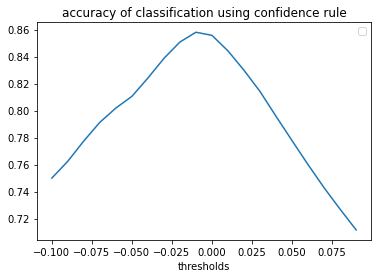

In [210]:
thresholds = np.arange(-0.1, 0.1, 0.01)
accuracy = []
mean_accuracy = []
for threshold in tqdm(thresholds):
    kf = KFold(n_splits=5, shuffle=True, random_state=500)
    for train, test in kf.split(X):
        X_train, X_test, y_train, y_test = X.loc[train, :], X.loc[test, :], y[train], y[test]
        accuracy.append(confidence(X_train.values, y_train.values, X_test.values, y_test.values, threshold)[0])
    mean_accuracy.append(np.mean(accuracy))
    
plt.plot(thresholds, mean_accuracy)
plt.legend()
plt.title('accuracy of classification using confidence rule')
plt.xlabel('thresholds')

### Performing cross-validation with best chosen parameters to estimate quality of classification

In [231]:
kf = KFold(n_splits=5, shuffle=True, random_state=400)
accuracy, precision, recall = [], [], []
for train, test in kf.split(X):
    X_train, X_test, y_train, y_test = X.loc[train, :], X.loc[test, :], y[train], y[test]
    accuracy.append(power(X_train.values, y_train.values, X_test.values, y_test.values, -0.05)[0])
    precision.append(power(X_train.values, y_train.values, X_test.values, y_test.values, -0.05)[1])
    recall.append(power(X_train.values, y_train.values, X_test.values, y_test.values, -0.05)[2])
print("Accuracy", np.mean(accuracy))
print("Precision", np.mean(precision))
print("Recall", np.mean(recall))
print("tn, fp, fn, tp", power(X_train.values, y_train.values, X_test.values, y_test.values, -0.05)[3].ravel())

Accuracy 0.8461538461538461
Precision 0.9479895594601478
Recall 0.7923921577529102
tn, fp, fn, tp [40  3 13 48]


In [237]:
kf = KFold(n_splits=5, shuffle=True, random_state=400)
accuracy, precision, recall = [], [], []
for train, test in kf.split(X):
    X_train, X_test, y_train, y_test = X.loc[train, :], X.loc[test, :], y[train], y[test]
    accuracy.append(support(X_train.values, y_train.values, X_test.values, y_test.values, -0.1)[0])
    precision.append(support(X_train.values, y_train.values, X_test.values, y_test.values, -0.1)[1])
    recall.append(support(X_train.values, y_train.values, X_test.values, y_test.values, -0.1)[2])
print("Accuracy", np.mean(accuracy))
print("Precision", np.mean(precision))
print("Recall", np.mean(recall))
print("tn, fp, fn, tp", support(X_train.values, y_train.values, X_test.values, y_test.values, -0.05)[3].ravel())

Accuracy 0.8615384615384615
Precision 0.8738519518926902
Recall 0.9056170030347193
tn, fp, fn, tp [43  0 36 25]


In [236]:
kf = KFold(n_splits=5, shuffle=True, random_state=400)
accuracy, precision, recall = [], [], []
for train, test in kf.split(X):
    X_train, X_test, y_train, y_test = X.loc[train, :], X.loc[test, :], y[train], y[test]
    accuracy.append(confidence(X_train.values, y_train.values, X_test.values, y_test.values, -0.015)[0])
    precision.append(confidence(X_train.values, y_train.values, X_test.values, y_test.values, -0.015)[1])
    recall.append(confidence(X_train.values, y_train.values, X_test.values, y_test.values, -0.015)[2])
print("Accuracy", np.mean(accuracy))
print("Precision", np.mean(precision))
print("Recall", np.mean(recall))
print("tn, fp, fn, tp", confidence(X_train.values, y_train.values, X_test.values, y_test.values, -0.05)[3].ravel())

Accuracy 0.9384615384615385
Precision 0.9965517241379309
Recall 0.9028017804222361
tn, fp, fn, tp [28 15  3 58]


Comparing to some other methods - SVM

In [238]:
from sklearn import svm

In [239]:
kf = KFold(n_splits=5, shuffle=True, random_state=400)
accuracy, precision, recall = [], [], []
y_pred = []
for train, test in kf.split(X):
    X_train, X_test, y_train, y_test = X.loc[train, :], X.loc[test, :], y[train], y[test]
    clf = svm.SVC()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    recall_score(y_test, y_pred), confusion_matrix(y_test, y_pred)
    accuracy.append(accuracy_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
print("Accuracy", np.mean(accuracy))
print("Precision", np.mean(precision))
print("Recall", np.mean(recall))
print("tn, fp, fn, tp", confusion_matrix(y_test, y_pred).ravel())

Accuracy 0.9634615384615385
Precision 0.9788742385194216
Recall 0.9620030896939307
tn, fp, fn, tp [41  2  2 59]
